In [1]:
from typing import List

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.fftpack import ifft

from collections import deque

In [2]:
import sys
sys.path.append('/home/thomas/projects/fair/call_3/repository/')

from src.pulsed_power_ml.model_framework.data_io import read_training_files
from src.pulsed_power_ml.model_framework.visualizations import add_contour_plot
from src.pulsed_power_ml.model_framework.visualizations import make_gupta_switch_detection_plot

2023-01-31 11:23:58.122843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 11:23:59.347771: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 11:23:59.347802: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-31 11:24:02.780245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-3

In [67]:
BASE_FOLDER = "/home/thomas/projects/fair/call_3/data/"
RAW_DATA_FOLDER = f"{BASE_FOLDER}/raw_data/2022-11-16_training_data/"

TEST_DATA_FOLDER = f'{RAW_DATA_FOLDER}/fp1/'

TEST_VOLTAGE_SPECTRUM = f'{TEST_DATA_FOLDER}/FFTApparentPower_FP1OffOn_FFTSize131072'

OUTPUT_FOLDER = f'/home/thomas/projects/fair/call_3/experiments/gupta_switch_detection/'

FFT_SIZE = 2**17

In [68]:
voltage_fft_raw = np.fromfile(TEST_VOLTAGE_SPECTRUM, dtype=np.float32)
remainder = len(voltage_fft_raw) % FFT_SIZE
if remainder != 0:
    voltage_fft_raw = voltage_fft_raw[:-remainder].reshape((-1, FFT_SIZE))
else:
    voltage_fft_raw = voltage_fft_raw.reshape((-1, FFT_SIZE))

In [69]:
def gupta_switch_detection(spectrum_array, window_size=25):

    index = 0

    difference_vector_max = list()

    while True:
        try:
            i, j, k = index*window_size, (index+1)*window_size, (index+2)*window_size
            background = np.mean(spectrum_array[i:j], axis=0)
            new_window = np.mean(spectrum_array[j:k], axis=0)
            difference_vector = background - new_window
            difference_vector_max.append(np.abs(difference_vector).max())
            index += 1

            if k > len(spectrum_array):
                break

        except:
            print(f'Exception! {i, j, k}, {len(spectrum_array)}')
            break

    return difference_vector_max

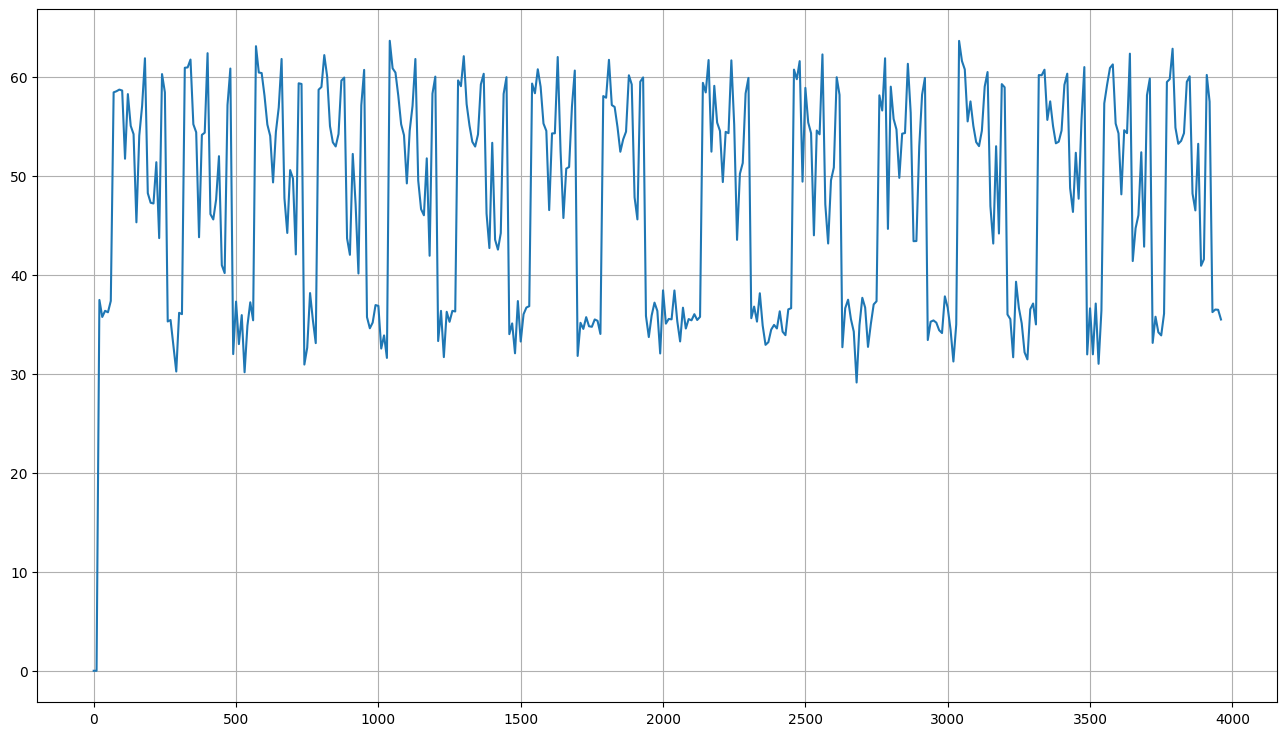

In [70]:

window_size = 10

gupta_switch_vector = gupta_switch_detection(voltage_fft_raw, window_size=window_size)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.plot(
    np.array(range(len(gupta_switch_vector))) * window_size,
    list([0]) * 2 + list(10*np.log10(gupta_switch_vector) + 30)[:-2]
)
# ax.hlines(y=2000, xmin=0, xmax=2000)
ax.grid(True)

In [71]:
fig.savefig('/home/thomas/projects/fair/call_3/experiments/gupta_switch_detection/reimplemented_gupta_switch_detection/intermediate/FP1_dbm_threshold.pdf')

In [ ]:
def add_contour_plot_dbm(spectrum: np.array,
                         min_max_freq: List[float],
                         ax: mpl.axis.Axis) -> mpl.axis.Axis:
    """
    Add a contour plot of the provided spectrum to *axes*.

    Parameters
    ----------
    spectrum
        Array containing the magnitude per frequency.
    min_max_freq:
        Array containing the min frequency and the max frequency.
    ax
        Axis object to add the plot to.

    Returns
    -------
    ax
        the provided axis object with the respective plot added.
    """

    # add spectrum to axis
    ax.imshow(X=10 * np.log10(spectrum.T**2 / 50.0) + 30,
              aspect="auto",
              interpolation="none",
              origin="lower",
              cmap=mpl.colormaps["rainbow"])

    # add frequency ticks to y-axis
    y_labels = np.arange(min_max_freq[0], min_max_freq[1]+1, 250)
    y_ticks_position_list = np.linspace(0, len(spectrum[0]), len(y_labels))
    ax.set_yticks(ticks=y_ticks_position_list,
                  labels=y_labels)
    ax.set_ylabel("Frequency [kHz]")

    # add time ticks
    ax.set_xlabel("Timestep")

    # Miscellaneous
    ax.grid(True)

    return ax

In [ ]:
def invert_fft(spectrum_array: np.array, fft_size: int) -> np.array:
    signal_list = list()
    for spectrum in spectrum_array:
        signal = ifft(spectrum)
        signal_list.append(signal)

    signal_sequence = np.array(signal_list).flatten()

    return signal_sequence

In [ ]:
signal_seq = invert_fft(voltage_fft_raw, FFT_SIZE)

In [ ]:
plt.plot(signal_seq)

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
real_part = voltage_fft_raw[:500, 0:int(FFT_SIZE/2)]
ax = add_contour_plot_dbm(real_part,
                          [0, 1000],
                          ax)
fig.savefig(f'{OUTPUT_FOLDER}/mixed1_voltage_spectrum_dBm.png', dpi=1600)

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
real_part = voltage_fft_raw[:500,327:int(FFT_SIZE/2)]
ax = add_contour_plot_dbm(real_part,
                          [10, 1000],
                          ax)
#fig.savefig(f'{OUTPUT_FOLDER}/l2_voltage_spectrum_50k_dbm.png', dpi=400)
fig.savefig(f'{OUTPUT_FOLDER}/mixed_voltage_spectrum_10k_dbm.png', dpi=1600)

In [ ]:
def clean_spectra(spectrum_array: np.array, background_n: int = 25, threshold: float = 10) -> np.array:
    background_array = deque(maxlen=background_n)
    output_array = np.full(spectrum_array.shape, np.nan)
    for index, spectrum_v in enumerate(spectrum_array):

        spectrum = 10 * np.log10(spectrum_v**2 / 50.0) + 30

        # Fill up background array until full
        if len(background_array) < background_n:
            background_array.append(spectrum)
            continue

        # clean current spectrum
        averaged_background = np.array(background_array).mean(axis=0)
        residual_spectrum = spectrum - averaged_background
        output_array[index] = residual_spectrum

        # check for switching event
        # if residual_spectrum.max() >= threshold

        background_array.append(spectrum)

    return output_array

In [ ]:
real_part = voltage_fft_raw[: ,1180:int(FFT_SIZE/2)]
cleaned_spectra = clean_spectra(real_part, 10)

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.plot(cleaned_spectra.max(axis=1))
ax.grid()

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.plot(cleaned_spectra.min(axis=1))
ax.grid()

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax.plot(np.abs(cleaned_spectra).max(axis=1))
ax.grid()

In [ ]:
plt.plot(cleaned_spectra.min(axis=1))

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
ax = add_contour_plot_dbm(cleaned_spectra,
                          [3, 1000],
                          ax)
#fig.savefig(f'{OUTPUT_FOLDER}/l2_voltage_spectrum_50k_dbm.png', dpi=400)
fig.savefig(f'{OUTPUT_FOLDER}/l2_voltage_cleaned_spectrum_10k_dbm.png', dpi=1600)

In [ ]:
a = np.zeros(10)

In [ ]:
a

In [ ]:
a[3:5] = 1

In [ ]:
a